Homework 2: Clustering
=============

In this homework, you will have the chance to implement two algorithms for clustering, namely the KMeans and Gaussian Mixture Model (GMM). Specifically:

- Implement K-Means algorithm, as well as the helper function like fast pairwise distance.
- Implement GMM, as well as the numerical stable helper functions.


# 0. Setup

This notebook is tested under [python 3.6.8](https://www.python.org/downloads/release/python-368/), and the corresponding packages can be downloaded from [miniconda](https://docs.conda.io/en/latest/miniconda.html). You may also want to get yourself familiar with several packages:

- [jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/)
- [numpy](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [matplotlib](https://matplotlib.org/users/pyplot_tutorial.html)


## Instructions for the assignment

- For coding questions: you are asked to fill in the blanks in the code cells.

You are only allowed to use the packages imported below. Other packages like scipy, sklearn are not allowed in this homework. The purpose is to let you write most part of the algorithms from scratch, so you can have a better understanding about them.

- For writing questions: you are asked to answer them in the markdown cells.

You can also type the Latex equations in the markdown cell. 
To switch between cell for code and for markdown, see the menu -> Cell -> Cell Type

- The total score for this assignment is 100. For coding questions, try to implement with matrix operations in numpy, and make sure it is not running too slow.

In [46]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

%matplotlib inline  

import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm_notebook as tqdm

print('Version information')

print('python: {}'.format(sys.version))
print('matplotlib: {}'.format(matplotlib.__version__))
print('numpy: {}'.format(np.__version__))

Version information
python: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 18:50:55) [MSC v.1915 64 bit (AMD64)]
matplotlib: 2.1.2
numpy: 1.15.4


# 1. Helper functions (21 pt)

In this section, you are asked to implement several mathematical functions that will be used later in your implementation for KMeans and GMM. 

You are expected to receive the exact same output with your implementation.

## pairwise distance (7 pt)

Given $X \in \mathbb{R}^{N x D}$ and $Y \in \mathbb{R}^{M x D}$, obtain the pairwise distance matrix $dist \in \mathbb{R}^{N x M}$, where $dist_{i, j} = ||X_i - Y_j||_2$

In [47]:
def pairwise_dist(x, y):
    """
    Args:
        x: N x D numpy array
        y: M x D numpy array
    Return:
        dist: N x M array, where dist2[i, j] is the euclidean distance between 
        x[i, :] and y[j, :]
    """
    dist = np.sum((x[None, :] - y[:, None]) **2, -1 )**0.5
    dist = np.transpose(dist)
    return dist
    raise NotImplementedError

np.random.seed(1)
x = np.random.randn(2, 2)
y = np.random.randn(3, 2)
print("==x==")
print(x)
print("==y==")
print(y)
print("==dist==")
print(pairwise_dist(x, y))

==x==
[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]]
==y==
[[ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]]
==dist==
[[1.85239052 0.19195729 1.35467638]
 [1.85780729 2.29426447 1.18155842]]


## softmax  (7 pt)

Given $logit \in \mathbb{R}^{N x D}$, calculate $prob \in \mathbb{R}^{N x D}$, where $prob_{i, j} = \frac{\exp(logit_{i, j})}{\sum_{d=1}^D exp(logit_{i, k})}$.

Note that it is possible that $logit_{i, j}$ is very large, making $\exp(\cdot)$ of it to explode. To make sure it is numerical stable, you may need to subtract the maximum for each row of $logits$

In [48]:
def softmax(logits):
    
    logits = logits - np.expand_dims(np.max(logits,1), 1)
    logits = np.exp(logits)
    axis_sum = np.expand_dims(np.sum(logits, 1),1)
    p = logits / axis_sum
    return p
    raise NotImplementedError

logits = np.array([[1000, 1000], 
                   [1, 2]], dtype=np.float32)
print("===softmax===")
print(softmax(logits))

===softmax===
[[0.5        0.5       ]
 [0.26894143 0.7310586 ]]


## logsumexp  (7 pt)

Given $logit \in \mathbb{R}^{N x D}$, calculate $s \in \mathbb{R}^N$, where $s_i = \log \big( \sum_{j=1}^D \exp(logit_{i, j}) \big)$. Again, pay attention to the numerical problem. You may want to use similar trick as in the softmax function.

In [49]:
def logsumexp(logits):
    i = logits.shape[0]
    #handle over and underflow
    logits = np.rollaxis(logits, 1)
    vmax = logits.max(axis=0)
    out = np.log(np.sum(np.exp(logits - vmax), axis=0))
    out += vmax
    out = out.reshape(i,1)
    return out

    raise NotImplementedError

logits = np.array([[1000, 1000], 
                   [1, 2]], dtype=np.float32)
print("===logsumexp===")
print(logsumexp(logits))

===logsumexp===
[[1000.6932   ]
 [   2.3132617]]


In [50]:
# below are some helper functions for plot.
# you don't have to modify them. 

def plot_images(img_list, title_list, figsize=(11, 6)):
    assert len(img_list) == len(title_list)
    fig, axes = plt.subplots(1, len(title_list), figsize=figsize)
    for i, ax in enumerate(axes):
        ax.imshow(img_list[i] / 255.0)
        ax.set_title(title_list[i])
        ax.axis('off')

def plot_scatter(samples, ids):
    colors = np.zeros((len(ids), 3))
    choices = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    num_points = []
    for i in range(3):
        num_points.append(np.sum(ids == i))
    maps = np.argsort(num_points)
    for i in range(3):
        colors[np.where(ids == maps[i]), :] = choices[i]
    plt.scatter(samples[:, 0], samples[:, 1], s=1, color=colors)
    plt.axis('equal')

# 2. KMeans implementation  (28 pt)

KMeans is trying to solve the following optimization problem:

\begin{align}
\arg \min_S \sum_{i=1}^K \sum_{x_j \in S_i} ||x_j - \mu_i||^2
\end{align}
where one needs to partition the N observations into K sets: $S = \{S_1, S_2, \ldots, S_K\}$ and each set has $\mu_i$ as its center.

In this section, you are asked to implement the kmeans algorithm. Below is a template which requires you to implement some member functions that haven't been implemented yet.

For the function signature, please see the corresponding doc strings.

In [21]:
class KMeans(object):

    def __init__(self):
        pass

    def _init_centers(self, points, K, **kwargs):
        centers = points[np.random.randint(points.shape[0], size= K)]
        return centers

    def _update_assignment(self, centers, points):
        distances = pairwise_dist(centers, points)
        cluster_idx = np.argmin(distances, axis=0)
        return cluster_idx

    def _update_centers(self, old_centers, cluster_idx, points):
        centers = np.empty((0, points.shape[1]))
        for i in range(old_centers.shape[0]):
            add = np.array(points[np.where(cluster_idx == i)].mean(axis=0))
            centers = np.append(centers, [add], axis=0)
        return centers

    def _get_loss(self, centers, cluster_idx, points):
        loss = 0 
        loss += pairwise_dist(points, centers)
        loss = np.sum(loss)
        return loss
    
    def __call__(self, points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, **kwargs):
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            max_iters: maximum number of iterations
            abs_tol: convergence criteria w.r.t absolute change of loss
            rel_tol: convergence criteria w.r.t relative change of loss
            kwargs: any additional arguments you want
        Return:
            cluster assignments: Nx1 int numpy array
            cluster centers: ? x D numpy array, the centers
        """
        centers = self._init_centers(points, K, **kwargs)
        pbar = tqdm(range(max_iters))
        for it in pbar:
            cluster_idx = self._update_assignment(centers, points)
            centers = self._update_centers(centers, cluster_idx, points)
            #print(centers)
            loss = self._get_loss(centers, cluster_idx, points)
            K = centers.shape[0]
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            pbar.set_description('iter %d, loss: %.4f' % (it, loss))
        return cluster_idx, centers

Let's try a simple image pixel clustering, which tries to compress the image using 5 colors:

[0 0 0 ... 4 4 4]


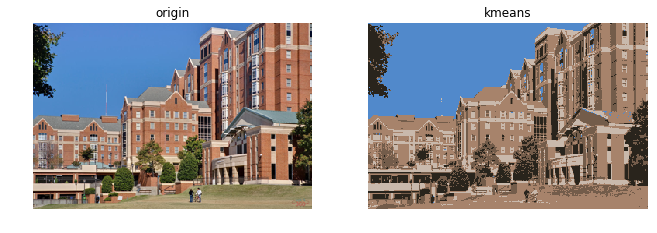

In [24]:
image = imageio.imread('gatech.bmp')
im_height, im_width, im_channel = image.shape

flat_img = np.reshape(image, [-1, im_channel]).astype(np.float32)

cluster_ids, centers = KMeans()(flat_img, K=5)
print(cluster_ids)


kmeans_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))

plot_images([image, kmeans_img], ['origin', 'kmeans'])

and 16 colors:

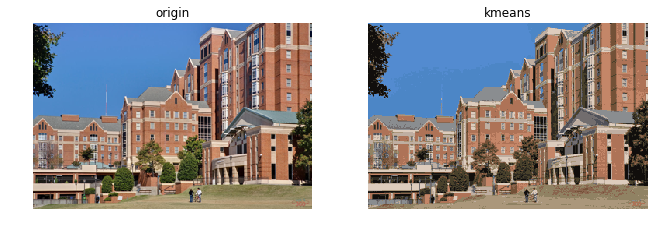

In [13]:
cluster_ids, centers = KMeans()(flat_img, K=16, max_iters=200)

kmeans_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))

plot_images([image, kmeans_img], ['origin', 'kmeans'])

# 3. GMM implementation  (28 pt)

GMM is trying to do MLE (maximum likelihood estimation). It approximates the distribution of data using a set of gaussian distributions. Here we assume that each gaussian component has diagonal covariance matrix, which makes it easier to calculate the density. 

Given $N$ samples $X = [x_1, x_2, \ldots, x_N]$, we are asked to find $K$ diagonal gaussian distributions to model the data $X$: 

\begin{align}
    \max_{\{\mu_k, \sigma_k\}_{k=1}^K} \sum_{i=1}^N \log \big( \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \sigma_k)\big)
\end{align}

Here $\pi(\cdot)$ is the prior of the latent variable. To make it simple, we assume $\pi(k) = \frac{1}{K}, \forall k = 1, 2, \ldots, K$.

In [51]:
class GMM(object):
    def __init__(self):
        pass
        
    def _init_components(self, points, K, **kwargs):
        pi = np.ones(K)
        mu = points[np.random.randint(points.shape[0], size= K)]
        #mu = KMeans()(points,K)
        sigma = points[np.random.randint(2, size= K)]
        return pi, mu, sigma
       
    def _ll_joint(self, points, pi, mu, sigma):
        ll = np.zeros((points.shape[0], mu.shape[0]))
        n = points.shape[0]
        for i in range(mu.shape[0]):
            func1 = (-1/2) * np.log(2* np.pi * sigma[i,:]**2)
            func2 = np.divide( (points-mu[i,:])**2  ,  -(2*sigma[i,:]**2)  )
            ll[:,i] = np.log(pi[i]) + np.sum(func1 + func2, axis = 1)
        return ll 

    def _E_step(self, points, pi, mu, sigma):
        gamma = self._ll_joint(points, pi, mu, sigma)
        gamma = softmax(gamma)
        return gamma

    def _M_step(self, points, gamma):
        weights = gamma.sum(axis=0)
        N = gamma.sum()
        pi = weights/N
        xn = points.sum(axis=0)
        mu = np.empty((0, points.shape[1]))
        sigma = np.empty((0, points.shape[1]))
        
        for k in range(gamma.shape[1]):
            a = np.multiply(gamma[:,k][:,np.newaxis], points)
            b = a.sum(axis=0)[np.newaxis,:]
            c = b / weights[k]
            mu = np.append(mu, c, axis=0)
            
        for k in range(gamma.shape[1]):
            a = np. multiply(gamma[:,k][:,np.newaxis] , (xn - mu[k])**2)
            b = a.sum(axis=0)[np.newaxis,:]
            c = b / weights[k]
            sigma = np.append(sigma, c, axis=0)      
        return pi , mu, sigma

    def __call__(self, points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, **kwargs):   
        pi, mu, sigma = self._init_components(points, K, **kwargs)
        pbar = tqdm(range(max_iters))
        for it in pbar:
            # E-step
            gamma = self._E_step(points, pi, mu, sigma)
            
            # M-step
            pi, mu, sigma = self._M_step(points, gamma)
            
            # calculate the negative log-likelihood of observation
            joint_ll = self._ll_joint(points, pi, mu, sigma)
            loss = -np.sum(logsumexp(joint_ll))
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            pbar.set_description('iter %d, loss: %.4f' % (it, loss))
        return gamma, (pi, mu, sigma)


Let's try a simple image pixel clustering, which tries to compress the image using 5 colors:

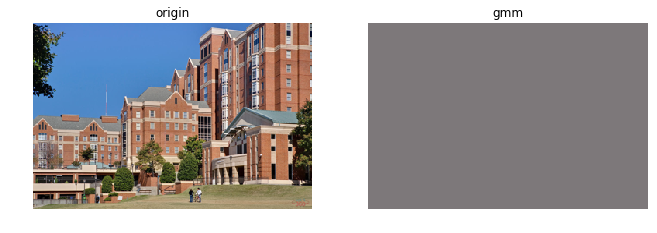

In [31]:
image = imageio.imread('gatech.bmp')
im_height, im_width, im_channel = image.shape
flat_img = np.reshape(image, [-1, im_channel]).astype(np.float32)
gamma, (pi, mu, sigma) = GMM()(flat_img, K=5, max_iters=200)
cluster_ids = np.argmax(gamma, axis=1)
centers = mu

gmm_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))

plot_images([image, gmm_img], ['origin', 'gmm'])

and 16 colors

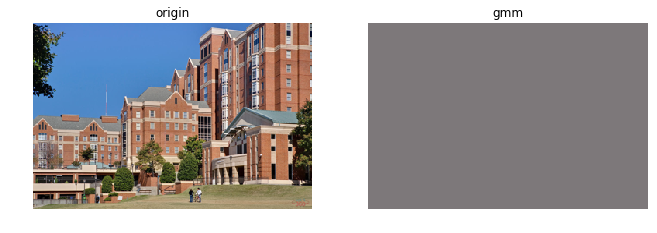

In [27]:
gamma, (pi, mu, sigma) = GMM()(flat_img, K=16, max_iters=300)
cluster_ids = np.argmax(gamma, axis=1)
centers = mu

gmm_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))

plot_images([image, gmm_img], ['origin', 'gmm'])

# 3. Compare KMeans with GMM  (7 pt)

In this section, we are going to have a comparison between the two algorithms.

## mixture model

We first create a dataset that is sampled from the mixture model. To do so, you first need a sampling method, that can sample from this mixture model. The sampling procedure looks like this:

- first sample a component id according to prior distribution $\pi(\cdot)$
- then choose the corresponding gaussian distribution, and sample from that gaussian


10000 3


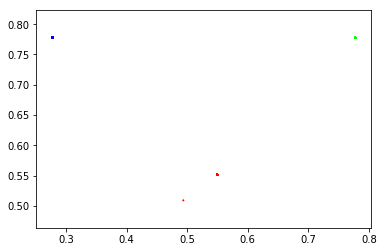

In [56]:
def gmm_sampling(num_samples, pi, mu, sigma):
    ids = np.random.choice(mu.shape[0], num_samples, p=pi)
    

    #for i in range(num_samples):
    samples = np.random.randn(num_samples, mu.shape[1])

    for i in range(samples.shape[0]):
        for k in range(mu.shape[0]):
            if ids[i] == k:
                samples[i,:] = sigma[k]*samples[k] + mu[k]
    print(samples.shape[0], mu.shape[0])


    return samples, ids
    """
    Args:
        num_samples: number of samples required
        pi: np array of length K, the prior distribution, where K is # components
        mu: KxD np array, the center for each gaussian, where D is data dimension
        sigma: KxD np array, the standard deviation for each gaussian
    Return:
        samples: NxD np array, the result samples
        ids: np array of length N, the component id for each sample
    """
    raise NotImplementedError

pi = np.array([0.8, 0.1, 0.1])
mu = np.array([[0.5, 0.5], 
               [0.25, 0.75], 
               [0.75, 0.75]], dtype=np.float32)
sigma = np.array([[0.1, 0.1], 
                  [0.05, 0.05], 
                  [0.05, 0.05]], dtype=np.float32)
samples, ids = gmm_sampling(10000, pi, mu, sigma)
plot_scatter(samples, ids)

Let's see how KMeans does in this case

C:\Users\Wataru\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice.
C:\Users\Wataru\Miniconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


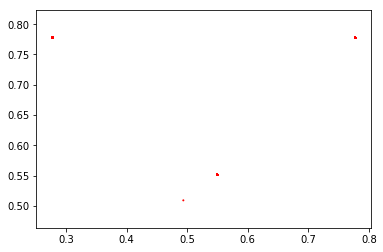

In [57]:
ids, centers = KMeans()(samples, K=3)
plot_scatter(samples, ids)

And GMM

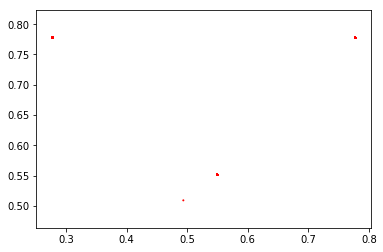

In [58]:
gamma, (pi, mu, sigma) = GMM()(samples, K=3, max_iters=1000)
ids = np.argmax(gamma, axis=1)
plot_scatter(samples, ids)

# 4. Written Questions  (16 pt)

In this section, you are asked to answer several question. You are expected to write down the answers in the notebook markdown cells (similar to the current one you are reading). You can also type Latex equations if necessary. 

## 4.1 Initialization.   (8 pt)

- What initialization method you used for KMeans and GMM, respectively? 

- Did you see different results after different runs of the same code? Why? 

Your answer goes here:



For both K means and GMM I used random numbers to pick existing points from the data. These points will be the intial center. This method is known as RP.

Different results are seen because the initializations are different, and the algorithms might reach to different local maxima.

## 4.2 Convergence.  (8 pt)

- Is it nguaranteed that GMM with EM always converges to the optimal solution? 

- Is KMeans always guaranteed to converge (to some local optima)? Please explain.

Your answer goes here:



It is not guranteed GMM with EM will always converge.  If variables μk and σk are unbounded, the likelihood function is unbounded. Thus, the EM algorithm might not converge to a local maximum. If n is large compared to k, it is very likely to find a non-degenrate local maximum. 

Kmeans will always  converge to local optima. J(X,Z)=min ∑z∈Clusters∑x∈data||x−z||^2 The objective function will oscillate, but local minima can be found based on max iteration or precision metrics. 